<h1><center>IMT2118 - Ciencia de Datos Geoespaciales </center></h1>
<h2><center>E2:  Islas de calor urbanas y violencia contra la mujer en Nueva York  </center></h2>

Cuando hablamos de violencia de género, nos referimos a conductas violentas cuya motivación última es la pertenencia a un género. Según la subcomisión de estadísticas de género (SEG), durante el año 2020 hubo 44 femicidos consumados y 163 intentos frustrados $^1$. Es por esto que la violencia de género es un problema relevante, el cual requiere de la formulación de políticas públicas para ser abordado correctamente.

Por otro lado, se encuentra el problema de las **islas de calor urbanas**, las cuales pueden ser definidas como zonas donde las estructuras como edificios y calles, entre otras estructuras, reemiten el calor proveniente del sol en mayor cantidad que los paisajes naturales. De esta manera, en zonas urbanas donde, por ejemplo, hay muy baja vegetación, se convierten en focos o "islas" de calor $^2$.

Si bien estos dos temas pueden parecer disconexos, diversos estudios que afirman que existe una correlación entre criminalidad y calor $^3$. Como menciona Robin Cooper, el incremento de temperatura causado por las islas de calor urbanas, generado por estructuras de asfalto y concreto y la limitación de espacios verdes, pueden contribuir al aumento de la violencia en verano dentro de las ciudades $^4$. A partir de esta idea, es de nuestro interés investigar si hay alguna correlación particular entre los crímenes con enfoque de género y las islas de calor.

Para los objetivos de este trabajo, se abordará exclusivamente la violencia ejercida desde hombres a mujeres, y limitada al siguiente subconjunto de crímenes obtenidos de las columnas de nuestro dataset: violación, acoso, secuestro, crímenes sexuales y homicidio. Los datos corresponden a los crímenes de 2022 en la ciudad de Nueva York.



**Referencias:**
1. Subcomisión de Estadísticas de Género (SEG) (n.d.). VIolencia de género. EstadíSticas de géNero. Retrieved July 2, 2023, from https://www.estadisticasdegenero.cl/indicadores/violencia-de-genero/

2. United States Enviromental Protection Energy (2022, September 2). Learn About Heat Islands. Retrieved July 5, 2023, from https://www.epa.gov/heatislands/learn-about-heat-islands

3. Sommer, A.J., Lee, M. & Bind, MA.C. Correction: Comparing apples to apples: an environmental criminology analysis of the effects of heat and rain on violent crimes in Boston. Palgrave Commun 5, 102 (2019). https://doi.org/10.1057/s41599-019-0313-y

4. Cooper, R. (2019, July 30). The Impacts of Extreme Heat on Mental Health. Psychiatric Times. Retrieved July 5, 2023, from https://www.psychiatrictimes.com/view/impacts-extreme-heat-mental-health

### 1. Importaciones y lecturas

In [20]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import geemap
from shapely.geometry import box
import numpy as np
import seaborn as sns
import libpysal as ps
from libpysal import weights
import esda
from time import time
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [3]:
# ee.Authenticate()
ee.Initialize()

In [35]:
big_crimes = gpd.read_file('NYPD_violence_against_women.gpkg')
big_crimes.to_crs('EPSG:4326', inplace=True)

In [36]:
manz = gpd.read_file('squares/nyct2020.shp')
manz.to_crs('EPSG:4326', inplace=True)
manz.head(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,PUMA,Shape_Leng,Shape_Area,geometry
0,1,1,Manhattan,000100,1000100,None,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,4121,10833.043929,1.843005e+06,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."


<Axes: >

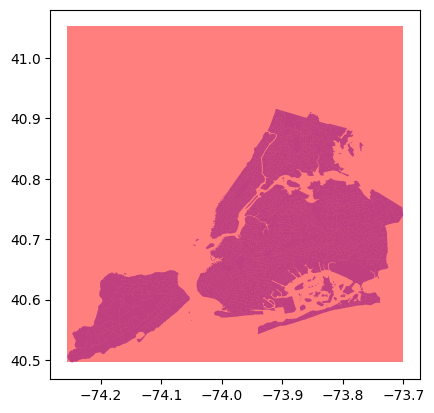

In [5]:
unif = manz.unary_union
bounding_box = unif.bounds
minx, miny, maxx, maxy = bounding_box
width = max(maxx - minx, maxy - miny)
expanded_bbox = box(minx, miny, minx + width, miny + width)
ny_box = gpd.GeoDataFrame(geometry=[expanded_bbox])
ax = manz.plot(color='blue', alpha=0.5)
ny_box.plot(ax=ax, color='red', alpha=0.5)

In [6]:
poly = ny_box.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon([xy[0], xy[1], xy[2], xy[3]])
x = aoi.centroid().getInfo()['coordinates'][0]
y = aoi.centroid().getInfo()['coordinates'][1]
aoi2 = ee.Geometry.Point([x-.1, y-.1])

### 2. Visualización de HeatMaps

In [7]:
def cloudMask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(1 << 3).Or(qa.bitwiseAnd(1 << 4))
    return image.updateMask(mask.Not())


def applyScaleFactors(image):
    thermalband = image.select('ST_B10').multiply(0.00341802).add(149.0).subtract(273.15)
    return image.addBands(srcImg=thermalband, overwrite=True)

In [8]:
# "LANDSAT/LE07/C01/T1"
# https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2

collection = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate('2022-05-30', '2022-07-10').map(cloudMask)
filtered_l8 = collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
landsatST = filtered_l8.map(applyScaleFactors)
mean_landsatST = landsatST.mean()
clip_mean_ST = mean_landsatST.clip(aoi)

images=collection.aggregate_array('system:id').getInfo()
print(len(images))

7


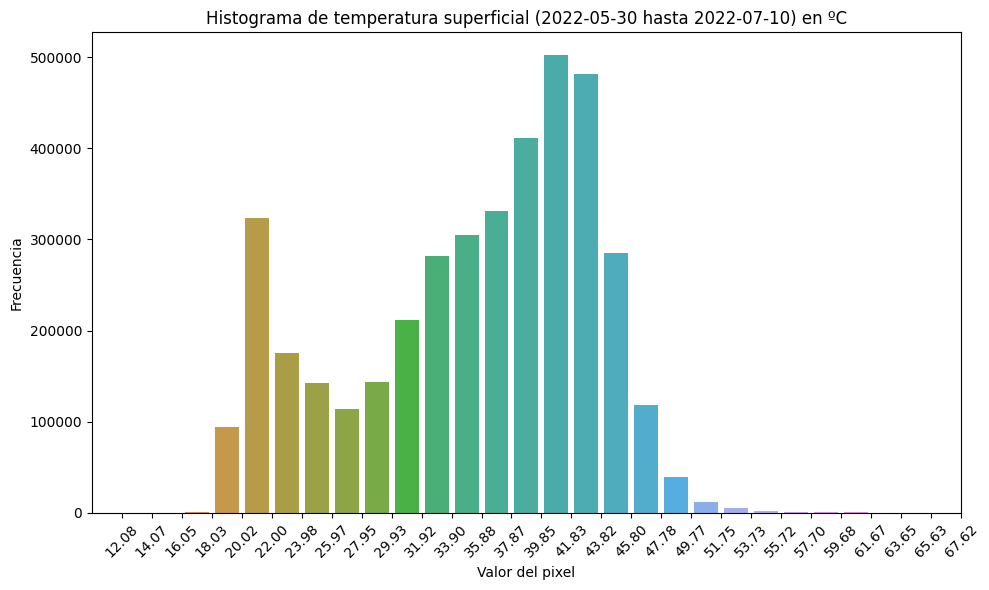

In [9]:
values_ST = clip_mean_ST.select('ST_B10')
histogram_ST = values_ST.reduceRegion(
    reducer=ee.Reducer.histogram(30),
    geometry=aoi,
    scale=30
)

values_ST = clip_mean_ST.select('ST_B10')
histogram_info = histogram_ST.get('ST_B10').getInfo()
histogram_values = histogram_info['histogram']
bucket_means = histogram_info['bucketMeans']

num_bins = len(histogram_values)
min_value = bucket_means[0] - (bucket_means[1] - bucket_means[0]) / 2
max_value = bucket_means[-1] + (bucket_means[-1] - bucket_means[-2]) / 2
bin_edges = np.linspace(min_value, max_value, num_bins + 1)

histogram_df = pd.DataFrame({'bin_edges': bin_edges[:-1], 'histogram_values': histogram_values})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=histogram_df, x='bin_edges', y='histogram_values')
plt.xlabel('Valor del pixel')
plt.ylabel('Frecuencia')
plt.title('Histograma de temperatura superficial (2022-05-30 hasta 2022-07-10) en ºC')

tick_positions = np.arange(len(bin_edges[:-1])) + 0.5
tick_labels = [f'{val:.2f}' for val in bin_edges[:-1]]
plt.xticks(tick_positions, tick_labels)
plt.xticks(rotation=45)
plt.tight_layout()

In [10]:
Map = geemap.Map()
heat_params = {'min': 20,
    'max': 50,
    'bands': 'ST_B10',
    'palette': ['blue', 'purple', 'yellow', 'orange','red']}
Map.addLayer(clip_mean_ST, heat_params, 'ST')
Map.centerObject(aoi2, 10)
Map

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

In [11]:
heat_islands = clip_mean_ST.gt(48).selfMask()
hi_params = {
    'bands': 'ST_B10',
    'palette': 'black'}
Map.addLayer(heat_islands, hi_params, 'Heat Islands')

A continuación, veremos añadiremos al plot distintos rangos de fechas.

In [12]:
layer_list = []
for i in range(1, 11):
    col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2").filterBounds(aoi).filterDate(f'2022-{i}-30', f'2022-{i+2}-10').map(cloudMask)
    filtered= collection.filter(ee.Filter.lt('CLOUD_COVER', 25))
    landST = filtered_l8.map(applyScaleFactors)
    mean_ST = landsatST.mean()
    clip_mean_ST = mean_landsatST.clip(aoi)
    layer_list.append(clip_mean_ST)

In [13]:
layer_list

In [ ]:
Map2 = geemap.Map()
for i,layer in enumerate(layer_list):
    layer
    Map2.addLayer(layer, heat_params, f'H.I 0{i+1}-30 to {i+3}-10')

Map2.centerObject(aoi2, 10)
Map2

Map(center=[40.673871012612906, -74.07780021318202], controls=(WidgetControl(options=['position', 'transparent…

### 3. Normalizar información de crímenes por cantidad de mujeres para el periodo relevante (2022)

In [51]:
every_manz_crimes = list()
for i in range(len(manz)):
    n_crimes = big_crimes.within(manz.iloc[i].geometry)
    every_manz_crimes.append(sum(n_crimes))
manz["n_crimes"] = every_manz_crimes

Ahora leemos el censo 2020 de NY, y nos quedamos con las manzanas en las cuales tenemos 

In [52]:
census_tracts = gpd.read_file('census/nyc_census_tracts.csv')

In [53]:
manz_filtered = manz[manz['GEOID'].isin(census_tracts['CensusTract'].unique())]
census_filtered = census_tracts[census_tracts['CensusTract'].isin(manz['GEOID'].unique())]

In [54]:
census_filtered = census_filtered[['CensusTract', 'TotalPop', 'Women']]

In [55]:
squares = manz_filtered.merge(census_filtered, left_on='GEOID', right_on='CensusTract')
squares = squares.drop('CensusTract', axis=1)

In [56]:
def proportion(TotalPop, subgroup):
    if float(TotalPop) == 0:
        return 0
    else:
        return float(subgroup)/float(TotalPop)

Normalizamos la variable de n_crimes (crimenes por manzana) respecto al área de cada manzana

In [57]:
cant_mujeres = sum(squares['Women'].astype('float64'))
squares['women_prop'] = squares.apply(lambda x: proportion(x.TotalPop, x.Women), axis=1)
squares['area_km2'] = squares.to_crs('EPSG:2263').geometry.area * 0.000000092903
squares['crimes_prop'] = squares.apply(lambda x: proportion(x.area_km2, x.n_crimes), axis=1)
squares.sample(3)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,PUMA,Shape_Leng,Shape_Area,geometry,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_prop
663,626,4,Queens,062600,4062600,None,Laurelton,QN1305,QN13,QN13 Queens Village-Bellerose-Rosedale (CD 13 ...,...,4413,9219.364873,4.651585e+06,"POLYGON ((-73.74319 40.68396, -73.74335 40.683...",9,3096,1702,0.549742,0.432146,20.826284
949,307,1,Manhattan,030700,1030700,None,Inwood,MN1203,MN12,MN12 Washington Heights-Inwood (CD 12 Equivalent),...,4112,4134.723010,9.055206e+05,"POLYGON ((-73.91401 40.87116, -73.91469 40.870...",5,3495,1621,0.463805,0.084126,59.434953
1758,912,3,Brooklyn,091200,3091200,None,Brownsville,BK1602,BK16,BK16 Ocean Hill-Brownsville (CD 16 Approximation),...,4316,5530.135917,1.800467e+06,"POLYGON ((-73.90517 40.66311, -73.90582 40.663...",64,6627,3997,0.603139,0.167269,382.617791


<Axes: >

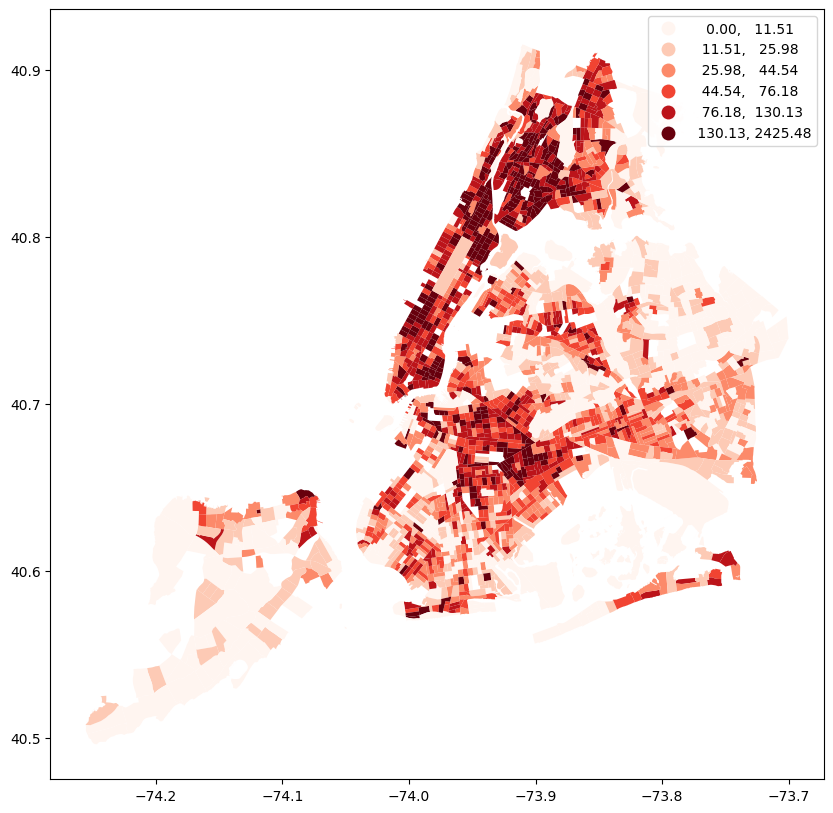

In [58]:
squares.plot(column='crimes_prop', scheme='quantiles', k=6, cmap='Reds', figsize=(10,10), legend=True)

### 4. Discretización de raster de temperatura

In [ ]:
clip_mean_ST.select('ST_B10').getInfo()['properties']['system:footprint']['coordinates'][0][:-1]

#### No correr siguiente código, se importará el dataframe que se generó

In [ ]:
'''
init = time()
squares['geometry_geojson'] = squares['geometry'].apply(lambda x: x.__geo_interface__)

mean_temperatures = []

for index, row in squares.iterrows():
    # Get the geometry of the row
    geometry = row['geometry_geojson']
    clipped_image = clip_mean_ST.clip(geometry)
    
    mean_temperature = clipped_image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ee.Geometry(geometry),
        scale=30
    ).get('ST_B10')
    
    mean_temperatures.append(mean_temperature.getInfo())
    if index%20==0:
        timer = time()
        delta = timer - init
        init = timer
        print(f'iteración {index}: {round(100*index/2034, 3)}% | Exec time: {delta}')

squares['mean_temperature'] = mean_temperatures
'''

Este código demora 35 min en correr, por lo que guardamos el dataframe y lo cargamos.

In [ ]:
# squares.to_file('squares_temperature.shp', driver="ESRI Shapefile")

In [61]:
squares = gpd.read_file('cuadras_temperatura/squares_temperature.shp')
squares.sample(1)

,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,...,Shape_Area,n_crimes,TotalPop,Women,women_prop,area_km2,crimes_pro,geometry_g,mean_tempe,geometry
213,202,2,Bronx,020200,2020200,None,Westchester Square,BX1001,BX10,BX10 Co-op City-Throgs Neck (CD 10 Approximation),...,1.343331e+06,7,2232,1166,0.522401,0.124799,56.08998,"{""type"": ""Polygon"", ""coordinates"": [[[-73.8445...",42.935436,"POLYGON ((-73.84458 40.83854, -73.84556 40.837..."


In [88]:
def is_heat_island(mean_temp):
    return 1 if mean_temp > 45 else 0

In [89]:
squares['heat_island'] = squares.apply(lambda x: is_heat_island(x.mean_tempe), axis=1)

Text(153.97222222222223, 0.5, 'Latitud')

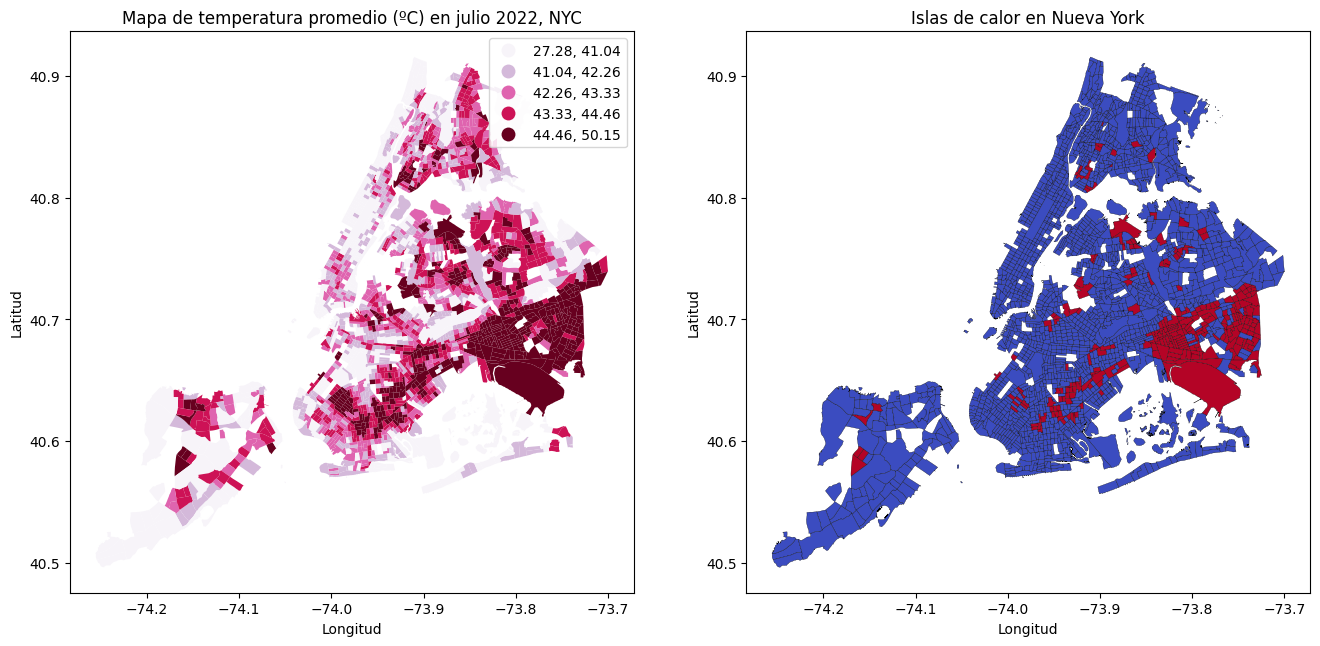

In [97]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[1], column='heat_island', categorical=True, cmap='coolwarm', linewidth=0.2, edgecolor='k', legend=False)
axes[1].set_title('Islas de calor en Nueva York')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

squares.plot(ax=axes[0], column='mean_tempe', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Mapa de temperatura promedio (ºC) en julio 2022, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

### 5. Análisis de autocorrelación espacial

Graficamos la temperatura de cada cuadra

Para calcular el lag espacial, normalizamos la variable mean_tempe (temperatura media de cada manzana)

In [7]:
mean = squares.crimes_pro.mean()
sd = squares.crimes_pro.std()
squares['crimes_prop_std'] = (squares['crimes_pro'] - mean)/sd
squares['index'] = squares.index

In [8]:
w = weights.Queen.from_dataframe(squares, ids='index')

/Users/terriblepollo/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 3 islands with ids: 0, 147, 1174.
  warnings.warn(message)


In [9]:
squares['crimes_prop_lag'] = weights.spatial_lag.lag_spatial(w, squares['crimes_prop_std'])

<Axes: title={'center': 'Crímenes de género, año 2022 (normalizado), NYC'}>

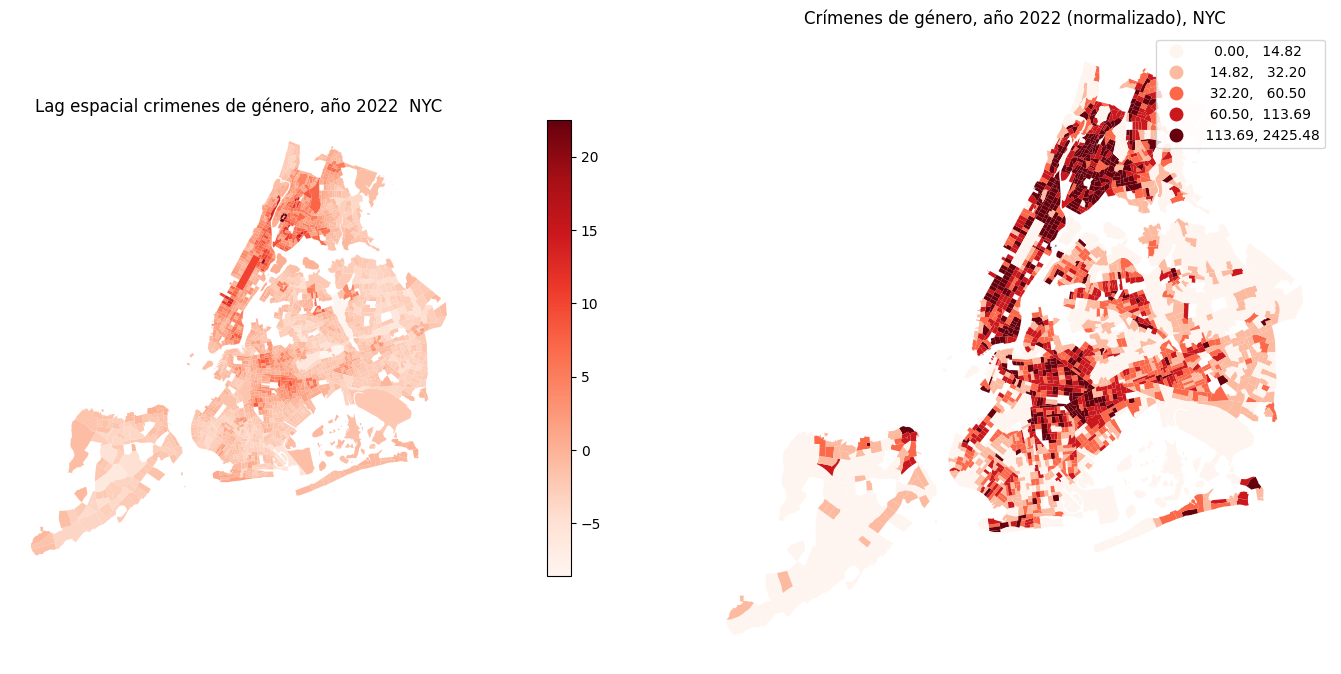

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))
axes[0].set_axis_off()
axes[0].set_title('Lag espacial crimenes de género, año 2022  NYC')
squares.plot(ax=axes[0], column='crimes_prop_lag', cmap='Reds', linewidth=0.4,legend=False)
ax_divider = make_axes_locatable(axes[0])
cax = ax_divider.append_axes("right", size="4%", pad="1%")
plt.colorbar(axes[0].collections[0],cax=cax)

axes[1].set_axis_off()
axes[1].set_title('Crímenes de género, año 2022 (normalizado), NYC')
squares.plot(ax=axes[1], column='crimes_pro', scheme='quantiles', k=5, cmap='Reds',legend=True)


#### a. Moran Global para temperatura y crímenes

Text(0.5, 1.0, 'Gráfico de moran: temperaturas promedio en Julio 2022')

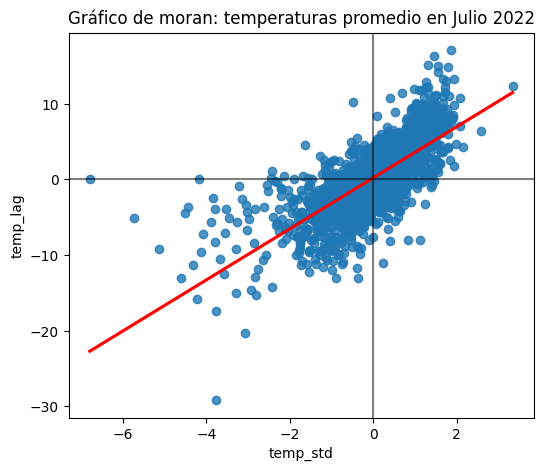

In [35]:
f, ax1 = plt.subplots(1, figsize=(6, 5))
ax1
sns.regplot(ax=ax1,
    x="temp_std",
    y="temp_lag",
    ci=None,
    data=squares,
    line_kws={"color": "r"},
)
ax1.axvline(0, c="k", alpha=0.5)
ax1.axhline(0, c="k", alpha=0.5)
ax1.set_title("Gráfico de moran: temperaturas promedio en Julio 2022")

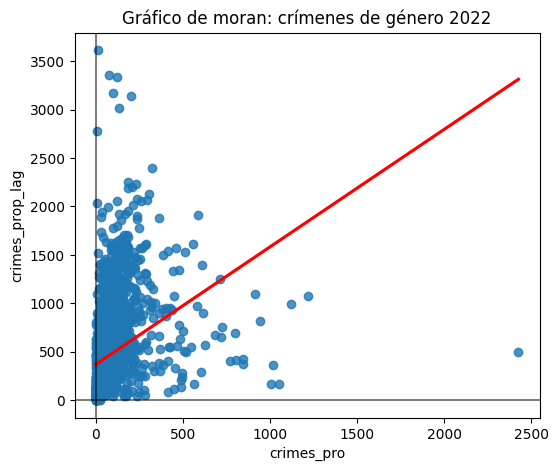

In [36]:
f, ax2 = plt.subplots(1, figsize=(6, 5))
sns.regplot(ax=ax2,
    x="crimes_pro",
    y="crimes_prop_lag",
    ci=None,
    data=squares,
    line_kws={"color": "r"},
)
ax2.axvline(0, c="k", alpha=0.5)
ax2.axhline(0, c="k", alpha=0.5)
ax2.set_title("Gráfico de moran: crímenes de género 2022")
plt.show()

In [37]:
w.transform = "R"
moran = esda.moran.Moran(squares["temp_lag"], w)
print(f'Heat -> Moran index: {moran.I} | p-value: {moran.p_sim}')

moran_crime = esda.moran.Moran(squares["crimes_prop_lag"], w)
print(f'crimenes de genero -> Moran index: {moran_crime.I} | p-value: {moran_crime.p_sim}')

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 147, ' is an island (no neighbors)')
('WARNING: ', 1174, ' is an island (no neighbors)')
Heat -> Moran index: 0.9171225382175238 | p-value: 0.001
crimenes de genero -> Moran index: 0.6872262205886382 | p-value: 0.001


Dado el alto valor del indice de Moran, y bajo valor p, hay una alta correlación global de los datos. (COMPLETAR)

#### b. Moran local para temperatura y crímenes

In [38]:
x=squares['temp_std']
y=squares['temp_lag']
lisa = esda.moran.Moran_Local(x, w)

Slope: 3.373794921745238
HH
LL
LH
HL


Text(0.5, 0.98, 'LISA para temperatura promedio')

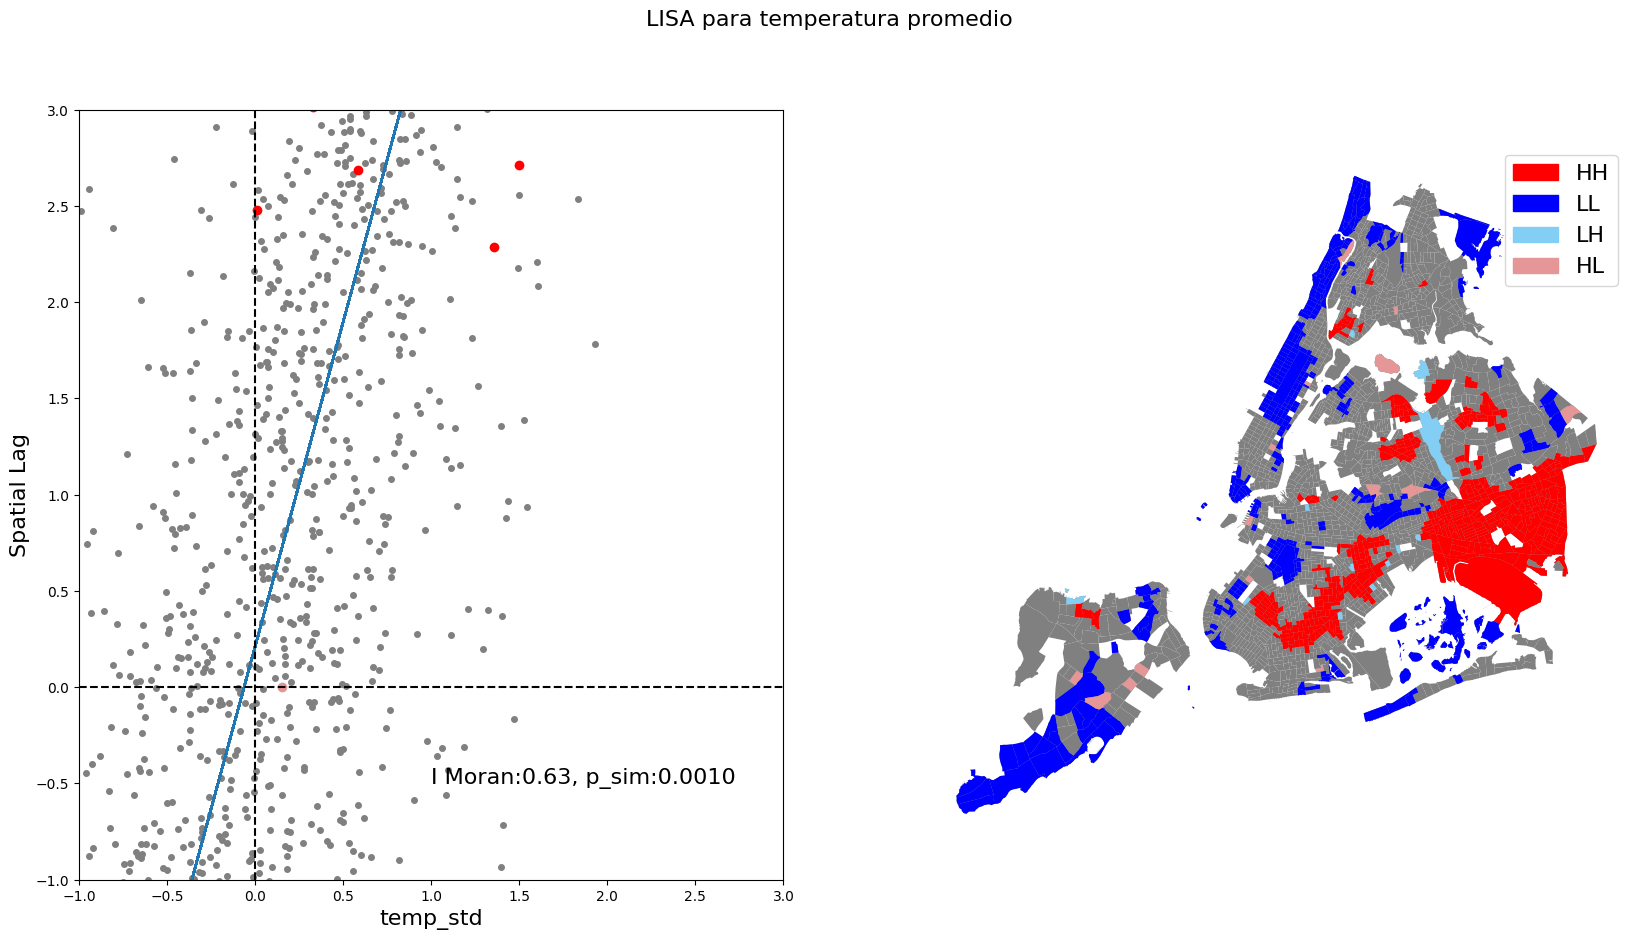

In [39]:
import matplotlib.patches as mpatches

squares['quadrant'] = lisa.q
squares['significant'] = lisa.p_sim < 0.05

quads={1:'HH',2:'LH',3:'LL',4:'HL'}
palette = {'LL': 'blue','HH':'red','LH':'#83cef4','HL':'#e59696'}

squares['quad_class'] = [quads[x] for x in squares['quadrant']]

HHm=(squares['significant']) & (squares['quadrant']==1) 
LLm=(squares['significant']) & (squares['quadrant']==3) 
HLm=(squares['significant']) & (squares['quadrant']==4) 
LHm=(squares['significant']) & (squares['quadrant']==2)

f,(ax,ax2) = plt.subplots(1,2, figsize=(20, 10))

m,b= np.polyfit(x, y, 1)
print('Slope:',m)
ax.plot(x,y,'o',color='gray',markersize=4)

ax.plot(x[HHm],y[HHm],'o',color='r',markersize=6)
ax.plot(x[LLm],y[LLm],'o',color='b',markersize=6)
ax.plot(x[LHm],y[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x[HLm],y[HLm],'o',color='#e59696',markersize=6)

ax.plot(x,m*x+b,ls='--')
ax.set_xlabel('temp_std',fontsize=16)
ax.set_ylabel('Spatial Lag' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

mi = esda.moran.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

sig=squares[squares['significant']]
squares.plot(color='gray',ax=ax2)

datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}
handles=[]

for ctype in datsig.keys():
    print(ctype)
    data=squares[datsig[ctype]]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para temperatura promedio', size=16)

Slope: 3.373794921745238
HH
LL
LH
HL


Text(0.5, 0.98, 'LISA para crímenes de género')

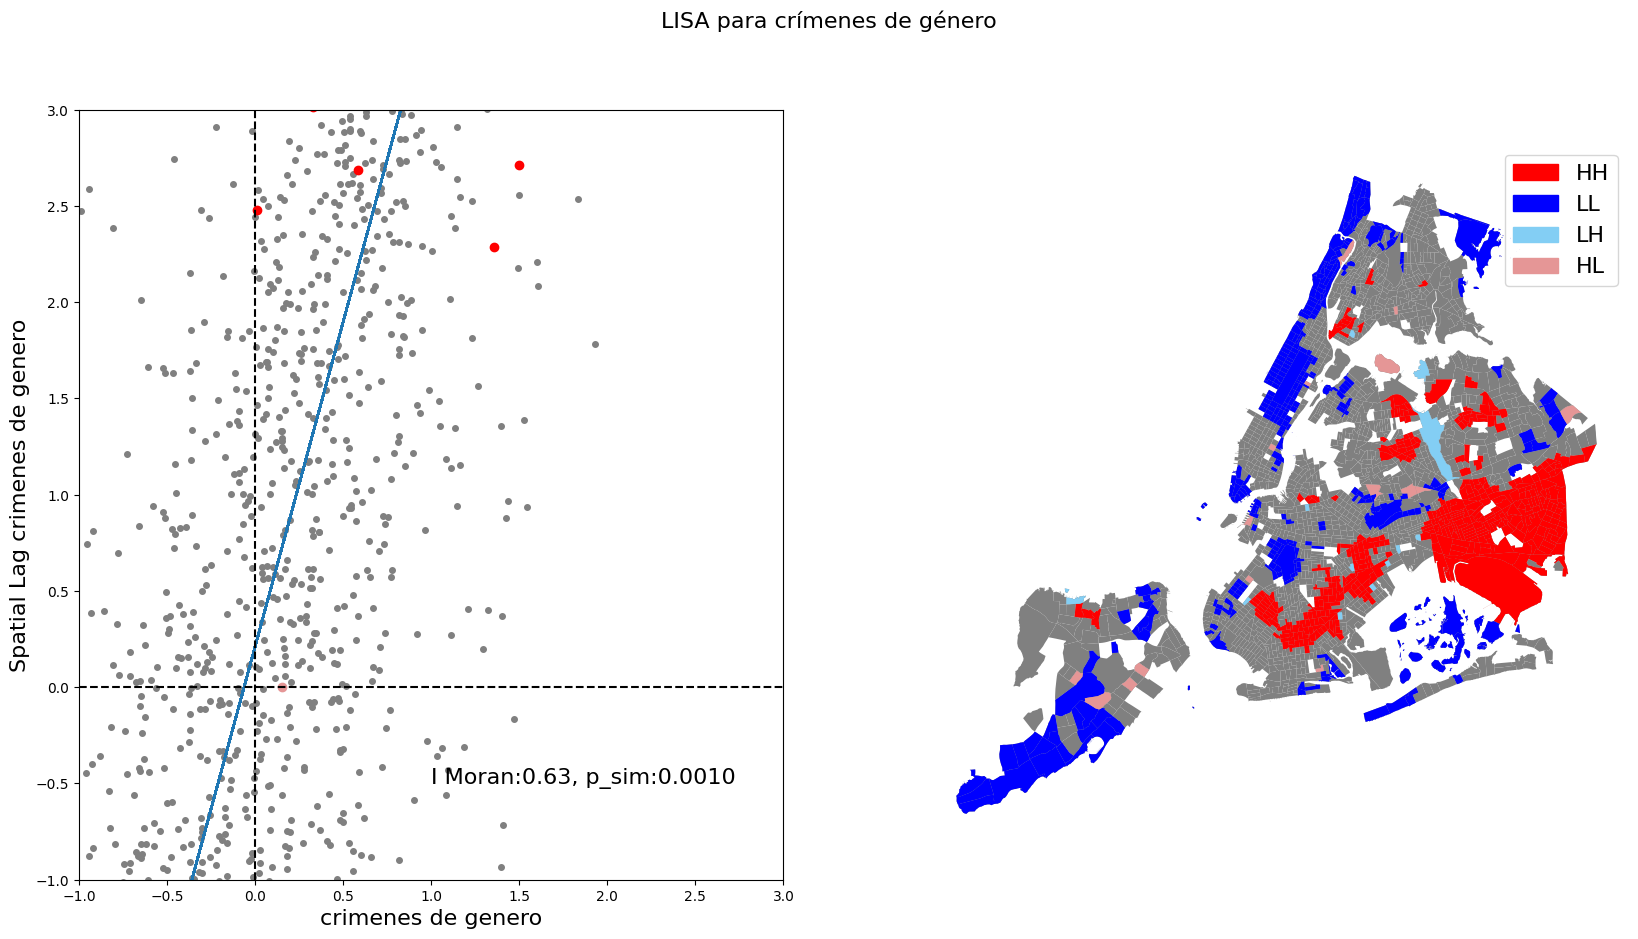

In [40]:
x_crime=squares['temp_std']
y_crime=squares['temp_lag']
lisa_crime = esda.moran.Moran_Local(x_crime, w)
squares['quadrant_crime'] = lisa.q
squares['significant_crime'] = lisa.p_sim < 0.05

squares['quad_class'] = [quads[x] for x in squares['quadrant_crime']]

HHm=(squares['significant_crime']) & (squares['quadrant_crime']==1) 
LLm=(squares['significant_crime']) & (squares['quadrant_crime']==3) 
HLm=(squares['significant_crime']) & (squares['quadrant_crime']==4) 
LHm=(squares['significant_crime']) & (squares['quadrant_crime']==2)

f,(ax,ax2) = plt.subplots(1,2, figsize=(20,10))

m,b= np.polyfit(x_crime, y, 1)
print('Slope:',m)
ax.plot(x_crime,y_crime,'o',color='gray',markersize=4)

ax.plot(x_crime[HHm],y_crime[HHm],'o',color='r',markersize=6)
ax.plot(x_crime[LLm],y_crime[LLm],'o',color='b',markersize=6)
ax.plot(x_crime[LHm],y_crime[LHm],'o',color='#83cef4',markersize=6)
ax.plot(x_crime[HLm],y_crime[HLm],'o',color='#e59696',markersize=6)

ax.plot(x_crime,m*x_crime+b,ls='--')
ax.set_xlabel('crimenes de genero',fontsize=16)
ax.set_ylabel('Spatial Lag crimenes de genero' ,fontsize=16)
ax.set_xlim(-1,3)
ax.set_ylim(-1,3)
ax.axhline(y=0,ls='--',color='k')
ax.axvline(x=0,ls='--',color='k')

mi = esda.moran.Moran(x, w)
ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim),fontsize=16)

sig=squares[squares['significant_crime']]
squares.plot(color='gray',ax=ax2)

datsig={'HH':HHm,'LL':LLm,'LH':LHm,'HL':HLm}
handles=[]

for ctype in datsig.keys():
    print(ctype)
    data=squares[datsig[ctype]]
    # Definir color para cada grupo
    color = palette[ctype]
    
    # Graficar grupo en el color correspondiente y agregar a leyenda
    hand=data.plot(color=color,ax=ax2,label=ctype)
    handles.append(mpatches.Patch(color=color, label=ctype))

plt.legend(handles=handles,loc='best',fontsize=16)
ax2.set_axis_off()
f.suptitle('LISA para crímenes de género', size=16)

Añadir interpretación

preguntas: Falta sacar heat islands. Podríamos ver quiza el moran de las heat islands? 

ola alfonso : ¿Cómo mezclar variables? Chat gpt recomienda sacar corr entre lag espacial del calor, y lag espacial de los crimenes, pero debemos considerar los tiempos de los crímenes. O como dijo la profe, si las heat islands son constantes en el tiempo, podríamos mostrar eso, y dps podemos usar todos los crímenes. :0, que opinas?

##### oli voy a ver los crimenes por meses

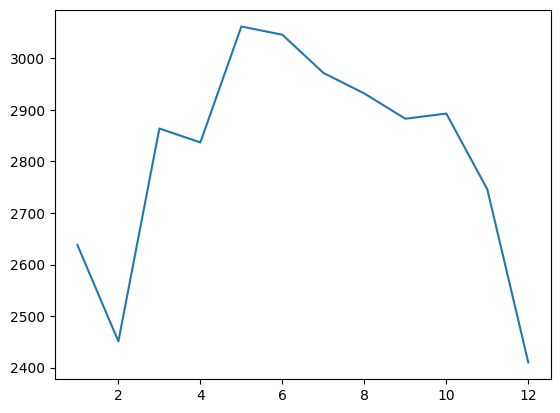

In [49]:
month_each_crime = [month for month in list(big_crimes["month"])]
crimes_by_month  = [month_each_crime.count(month) for month in range(1, 13)]
plt.plot(range(1, 13), crimes_by_month)

Golazo ono

##### graficos de heat islands y crimenes

Text(830.3358585858584, 0.5, 'Latitud')

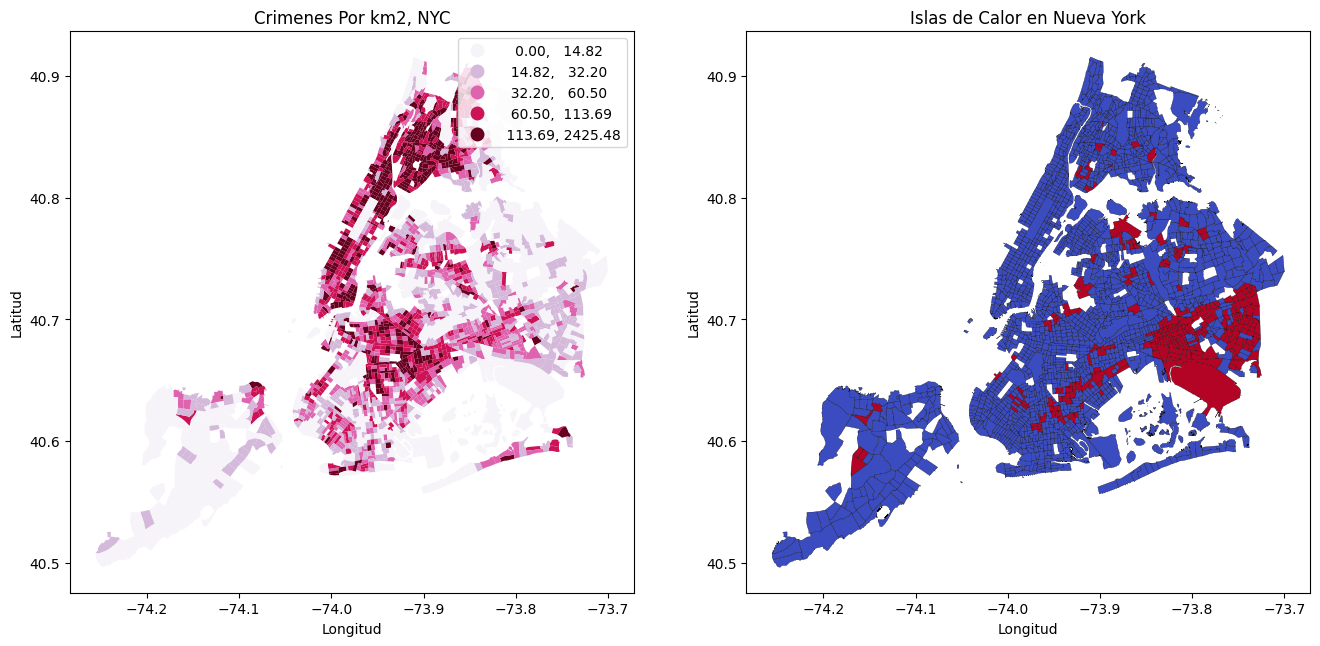

In [108]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[0], column='crimes_pro', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Crimenes Por km2, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

squares.plot(ax=axes[1], column='heat_island', categorical=True, cmap='coolwarm', linewidth=0.2, edgecolor='k', legend=False)
axes[1].set_title('Islas de Calor en Nueva York')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

In [104]:
min_temp = min(list(squares["mean_tempe"])); max_temp = max(list(squares["mean_tempe"]))
min_crim = min(list(squares["crimes_pro"])); max_crim = max(list(squares["crimes_pro"]))
squares["temp_norm"] = squares.apply(lambda x : (x.mean_tempe - min_temp)/(max_temp - min_temp), axis=1)
squares["crim_norm"] = squares.apply(lambda x : (x.crimes_pro - min_crim)/(max_crim - min_crim), axis=1)

Text(830.3358585858584, 0.5, 'Latitud')

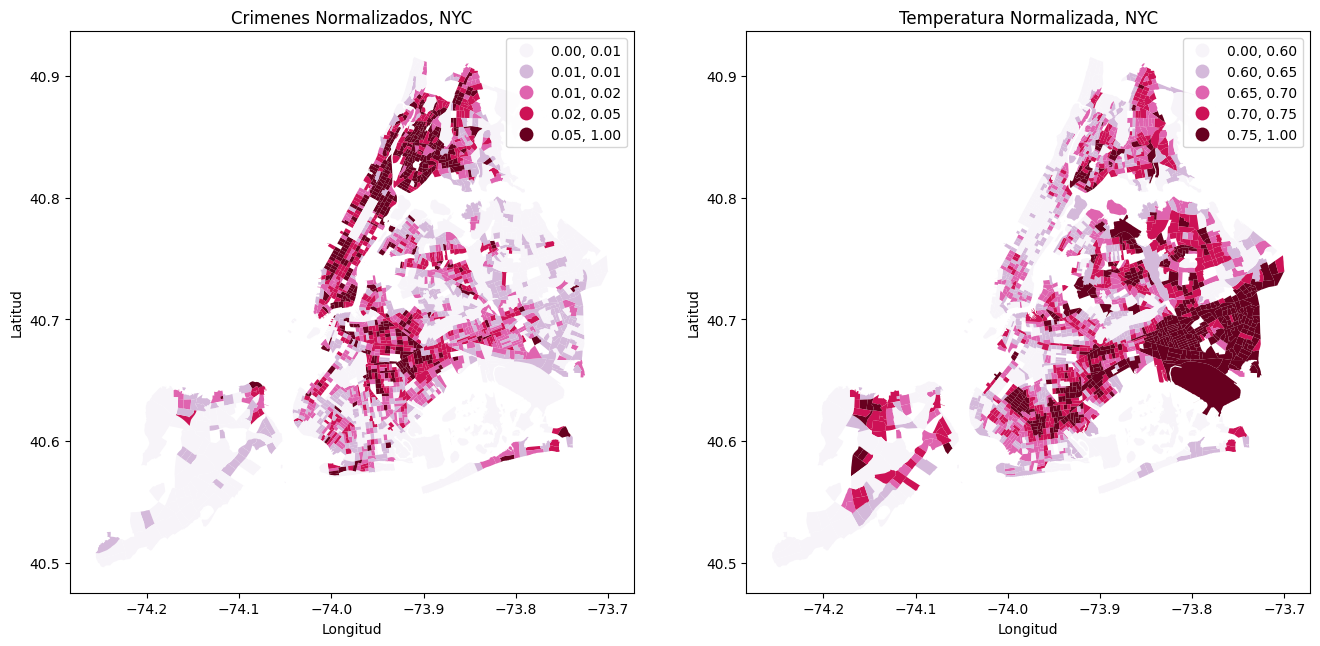

In [114]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

squares.plot(ax=axes[0], column='crim_norm', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[0].set_title('Crimenes Normalizados, NYC')
axes[0].set_xlabel('Longitud')
axes[0].set_ylabel('Latitud')

squares.plot(ax=axes[1], column='temp_norm', scheme='quantiles', linewidth=0.2, k=5, cmap='PuRd', legend=True)
axes[1].set_title('Temperatura Normalizada, NYC')
axes[1].set_xlabel('Longitud')
axes[1].set_ylabel('Latitud')

In [119]:
squares['crim_norm'].corr(squares['temp_norm'])

-0.01829255390884753

Se concluye que no hay correlación entre ambas varialbles.